# Анализ заказов билетов и пользовательской активности

- Автор: Максимов А.В.
- Дата: 29.03.2025

## Цели и задачи проекта

Коллеги из продуктовой команды просят провести исследовательский анализ данных в Python, чтобы выявить инсайты об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами.

## Описание данных

- `final_tickets_orders_df` — таблица включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных. Путь к файлу: `/datasets/final_tickets_orders_df`.

- `final_tickets_events_df` — таблица содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. Путь к файлу: `/datasets/final_tickets_events_df.csv`.

- `final_tickets_tenge_df.csv` — таблица с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. Путь к файлу: `/datasets/final_tickets_tenge_df.csv`.


**Поля таблицы `final_tickets_orders_df.csv`:**

- `order_id` — уникальный идентификатор заказа;

- `user_id` — уникальный идентификатор пользователя;

- `created_dt_msk` — дата создания заказа (московское время);

- `created_ts_msk` — дата и время создания заказа (московское время);

- `event_id` — идентификатор мероприятия из таблицы events;

- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет';

- `age_limit` — возрастное ограничение мероприятия;

- `currency_code` —  валюта оплаты, например rub для российских рублей;

- `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных;

- `revenue` — выручка от заказа;

- `service_name` — название билетного оператора;

- `tickets_count` — количество купленных билетов;

- `total` — общая сумма заказа.

**Поля таблицы `final_tickets_events_df.csv`:**

- `event_id` — уникальный идентификатор мероприятия;

- `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных;

- `event_type_description` — описание типа мероприятия;

- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее;

- `organizers` — организаторы мероприятия;

- `region_name` — название региона;

- `city_name` — название города;

- `venue_id` —  уникальный идентификатор площадки;

- `venue_name` — название площадки;

- `venue_address` — адрес площадки;

**Поля таблицы `final_tickets_tenge_df.csv`:**

- `nominal` — номинал (100 тенге);

- `data` — дата;

- `curs` — курс тенге к рублю;

- `cdx` — обозначение валюты (kzt);

##  Содержимое проекта
- Работа с данными
- Исследовательский анализ данных
- Статистический анализ данных
- Вывод и рекомендации

## Работа с данными

### Загрузка данных

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy import stats as st
import os

# Extract connection parameters
dbname = 'data-analyst-afisha'
user = 'praktikum_student'
password = 'Sdf4$2;d-d30pp'
host = 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net'
port = 6432

# Establish the connection
connection_string = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}"

# Create the SQLAlchemy engine
engine = create_engine(connection_string)

# Use pandas to read the purchase data
query = """
SELECT *,
       created_dt_msk::date - LAG(created_dt_msk) OVER(PARTITION BY user_id ORDER BY created_dt_msk)::date AS days_since_prev
FROM afisha.purchases
WHERE -- Фильтруем тип устройства
 device_type_canonical IN ('mobile',
                           'desktop'); 
"""
query_2 = """
SELECT -- Выгружаем данные таблицы events:
 e.event_id,
 e.event_name_code AS event_name,
 e.event_type_description,
 e.event_type_main,
 e.organizers, 
 -- Выгружаем информацию о городе и регионе:
 r.region_name,
 c.city_name,
 c.city_id, 
 -- Выгружаем информацию о площадке:
 v.venue_id,
 v.venue_name,
 v.address AS venue_address
FROM afisha.events AS e
LEFT JOIN afisha.venues AS v USING(venue_id)
LEFT JOIN afisha.city AS c USING(city_id)
LEFT JOIN afisha.regions AS r USING(region_id)
WHERE e.event_id IN
    (SELECT DISTINCT event_id
     FROM afisha.purchases
     WHERE -- Фильтруем тип устройства
 device_type_canonical IN ('mobile',
                           'desktop'))
  AND e.event_type_main != 'фильм';
"""

pth1 = '/final_tickets_tenge_df.csv'
pth2 = '/datasets/final_tickets_tenge_df.csv'

if os.path.exists(pth1):
    final_tickets_tenge_df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    final_tickets_tenge_df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [2]:
final_tickets_orders_df = pd.read_sql_query(query, engine)
final_tickets_orders_df.info()
final_tickets_orders_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               290849 non-null  int64         
 1   user_id                290849 non-null  object        
 2   created_dt_msk         290849 non-null  datetime64[ns]
 3   created_ts_msk         290849 non-null  datetime64[ns]
 4   event_id               290849 non-null  int64         
 5   cinema_circuit         290849 non-null  object        
 6   age_limit              290849 non-null  int64         
 7   currency_code          290849 non-null  object        
 8   device_type_canonical  290849 non-null  object        
 9   revenue                290849 non-null  float64       
 10  service_name           290849 non-null  object        
 11  tickets_count          290849 non-null  int64         
 12  total                  290849 non-null  floa

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [3]:
final_tickets_events_df = pd.read_sql_query(query_2, engine)
final_tickets_events_df.info()
final_tickets_events_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [4]:
final_tickets_tenge_df.info()
final_tickets_tenge_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


В целом, пропусков в столбцах не видно, кроме days_since_prev, который означет количество дней с предыдущей покупки, а если у человека и изначально покупки не было, значит там может быть пропуск, поэтому пустые значения в этом столбце не критично. Так же, если просмотреть таблицу final_tickets_tenge_df, то видно что датасет имеет 357 строк и отсутсвие пропусков в столбцах, что говорит нам о полноте данных в таблице. Единственное что полдребуется, так это поменять тип данных у столбца data на datetime.

### Предобработка данных

In [5]:
final_tickets_tenge_df['data'] = pd.to_datetime(final_tickets_tenge_df['data'])

Приводим выше названный столбец к нужному нам типу данных

In [6]:
df = final_tickets_orders_df.merge(final_tickets_events_df, left_on = 'event_id', right_on = 'event_id', how = 'left')

df = df.merge(final_tickets_tenge_df,left_on = 'created_dt_msk', right_on = 'data', how = 'left')

df = df.drop(columns=['cdx', 'nominal','data'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290849 entries, 0 to 290848
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290849 non-null  int64         
 1   user_id                 290849 non-null  object        
 2   created_dt_msk          290849 non-null  datetime64[ns]
 3   created_ts_msk          290849 non-null  datetime64[ns]
 4   event_id                290849 non-null  int64         
 5   cinema_circuit          290849 non-null  object        
 6   age_limit               290849 non-null  int64         
 7   currency_code           290849 non-null  object        
 8   device_type_canonical   290849 non-null  object        
 9   revenue                 290849 non-null  float64       
 10  service_name            290849 non-null  object        
 11  tickets_count           290849 non-null  int64         
 12  total                   290849

Тут мы объединили все 3 датасета, и получили одну большую таблицу на 24 столбца в 290849 строку, некоторые столбцы были удалены, так как не несут важной информации. Мы видим что датасет занимает 57.7 мегабайт, и дальше мы исправим эту ситуацию.

#### Пропуски в датасетах

In [7]:
print('Количество пропусков в датасете df')
df.isna().sum()

Количество пропусков в датасете df


order_id                      0
user_id                       0
created_dt_msk                0
created_ts_msk                0
event_id                      0
cinema_circuit                0
age_limit                     0
currency_code                 0
device_type_canonical         0
revenue                       0
service_name                  0
tickets_count                 0
total                         0
days_since_prev           21940
event_name                  238
event_type_description      238
event_type_main             238
organizers                  238
region_name                 238
city_name                   238
city_id                     238
venue_id                    238
venue_name                  238
venue_address               238
curs                          0
dtype: int64

Заметно, что очень сильно выделятся столбец days_since_prev, но про него мы уже раньше обсудили, поэтому ничео страшного, но мы видим пустые значения в столбцах от датасета final_tickets_events_df, что говорит нам о событиях, которые не нашлись, но так как их очень мало, если сравнивать с общим кол-во строк с которым мы работаем, их можно удалить

In [8]:
df = df.dropna(subset=['event_name'])
print('Количество пропусков в датасете df')
df.isna().sum()

Количество пропусков в датасете df


order_id                      0
user_id                       0
created_dt_msk                0
created_ts_msk                0
event_id                      0
cinema_circuit                0
age_limit                     0
currency_code                 0
device_type_canonical         0
revenue                       0
service_name                  0
tickets_count                 0
total                         0
days_since_prev           21913
event_name                    0
event_type_description        0
event_type_main               0
organizers                    0
region_name                   0
city_name                     0
city_id                       0
venue_id                      0
venue_name                    0
venue_address                 0
curs                          0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290848
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290611 non-null  int64         
 1   user_id                 290611 non-null  object        
 2   created_dt_msk          290611 non-null  datetime64[ns]
 3   created_ts_msk          290611 non-null  datetime64[ns]
 4   event_id                290611 non-null  int64         
 5   cinema_circuit          290611 non-null  object        
 6   age_limit               290611 non-null  int64         
 7   currency_code           290611 non-null  object        
 8   device_type_canonical   290611 non-null  object        
 9   revenue                 290611 non-null  float64       
 10  service_name            290611 non-null  object        
 11  tickets_count           290611 non-null  int64         
 12  total                   290611

Мы видим, что в каждом столбце теперь совпадают значения по кол-ву непустых строчек, кроме days_since_prev, о котором говорили ранее.

In [10]:
categorical_columns = ['event_type_main', 'device_type_canonical', 'age_limit', 'currency_code', 'service_name','cinema_circuit']
for col in categorical_columns:
    print(f"Уникальные значения в {col}:")
    print(df[col].sort_values().unique(), "\n")

Уникальные значения в event_type_main:
['выставки' 'другое' 'концерты' 'спорт' 'стендап' 'театр' 'ёлки'] 

Уникальные значения в device_type_canonical:
['desktop' 'mobile'] 

Уникальные значения в age_limit:
[ 0  6 12 16 18] 

Уникальные значения в currency_code:
['kzt' 'rub'] 

Уникальные значения в service_name:
['Crazy ticket!' 'Show_ticket' 'Билет по телефону' 'Билеты без проблем'
 'Билеты в интернете' 'Билеты в руки' 'Быстробилет' 'Быстрый кассир'
 'Весь в билетах' 'Восьмёрка' 'Вперёд!' 'Выступления.ру'
 'Городской дом культуры' 'Дом культуры' 'Дырокол' 'За билетом!'
 'Зе Бест!' 'КарандашРУ' 'Кино билет' 'Край билетов' 'Лимоны'
 'Лови билет!' 'Лучшие билеты' 'Мир касс' 'Мой билет' 'Облачко'
 'Прачечная' 'Радио ticket' 'Реестр' 'Росбилет' 'Тебе билет!' 'Телебилет'
 'Тех билет' 'Цвет и билет' 'Шоу начинается!' 'Яблоко'] 

Уникальные значения в cinema_circuit:
['Другое' 'КиноСити' 'Киномакс' 'Москино' 'ЦентрФильм' 'нет'] 



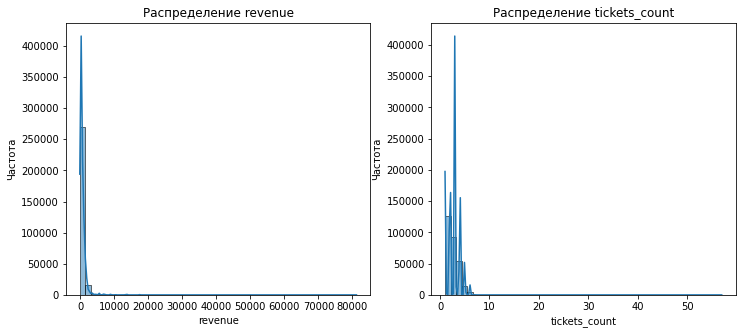

In [11]:
numerical_columns = ['revenue', 'tickets_count']
plt.figure(figsize=(12, 5))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(1, 2, i)
    sns.histplot(df[col], bins=50,kde=True)
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')

plt.show()

В категориальных данных проблем со значениями нету, но мы можем заметить, что названия сервисов схожи и зачастую имеют в название слово "Билет". Основная масса заказов сосредоточена в низком диапазоне, но имеются отдельные заказы с очень высокой стоимостью. Большинство заказов включает небольшое количество билетов, но встречаются заказы с большим числом билетов (до 50 штук).

#### Проверка на явные и неявные дубликаты

In [12]:
obvious_df = df.duplicated().sum()
print(f'Кол-во явных дубликатов в датасете df: {obvious_df}')

Кол-во явных дубликатов в датасете df: 0


In [13]:
k = df[df.duplicated(subset=[col for col in df.columns if col != "order_id"])]
k

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,curs
11778,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,...,спектакль,театр,№1482,Светополянский округ,Глиноград,54.0,4443.0,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50",18.8553
57220,160893,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,...,выставка,другое,№1810,Яблоневская область,Горяново,11036.0,1656.0,"Модная академия ""Пункт"" Лимитед","бул. Гагарина, д. 39",19.9516
84015,3363798,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,...,событие,выставки,№5015,Нежинская область,Каменёвка,76.0,3094.0,"Сообщество художников ""Палитра"" и партнеры","пр. Театральный, д. 161 стр. 2",18.8012
148477,2323916,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,нет,0,rub,mobile,26.96,...,спорт,спорт,№1503,Чистогорская область,Песчанская,21.0,2155.0,"Клуб моделей ""Гармония"" Инк","ул. Прохладная, д. 8 к. 432",19.9266
154173,5372831,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.84,...,событие,другое,№4403,Североярская область,Озёрск,2.0,2795.0,"Клуб исторических реконструкций ""Логос"" и парт...","пр. Пушкина, д. 8/6 к. 482",19.1903
154178,5373179,7eb4fc207ecc10f,2024-08-23,2024-08-23 14:08:19,298035,нет,6,rub,mobile,126.84,...,событие,другое,№4403,Североярская область,Озёрск,2.0,2795.0,"Клуб исторических реконструкций ""Логос"" и парт...","пр. Пушкина, д. 8/6 к. 482",19.1903
154993,3463819,7eb4fc207ecc10f,2024-09-21,2024-09-21 11:43:58,448579,нет,0,rub,mobile,2.54,...,спорт,спорт,№1622,Североярская область,Озёрск,2.0,4607.0,"Команда артистов ""Светлячок"" Лимитед","пер. Невского, д. 72",19.3316
156215,6657995,7eb4fc207ecc10f,2024-10-26,2024-10-26 09:39:03,418836,нет,0,rub,mobile,294.85,...,цирковое шоу,другое,№1703,Тепляковская область,Горнодолинск,43.0,4481.0,"Школа сценического мастерства ""Вдох"" Лтд","пер. Полярный, д. 87",19.9266
174584,6114564,8d6c1ff89fac35f,2024-10-31,2024-10-31 22:28:57,589624,нет,16,rub,desktop,41.83,...,концерт,концерты,№2121,Каменевский регион,Глиногорск,213.0,1365.0,"Картинная галерея ""Светлячок"" Лтд","ул. Дальневосточная, д. 97 к. 1/4",19.7383
176439,8248210,8f95286aa5fd8d7,2024-06-20,2024-06-20 10:57:19,244875,нет,0,rub,mobile,15.73,...,выставка,другое,№3906,Каменноозёрный край,Ордакент,12.0,2492.0,"Кинофестиваль ""Хранитель"" Инкорпорэйтед","пр. Балтийский, д. 8 к. 51",18.0419


Выше мы видим, что нам вывело 30 строк, которые удолетворяли условию, что все столбцы равны, кроме order_id. Это могло произойти из-за ошибки при выгрузке данных или при повторной регистрации одних и тех же заказов. 

In [14]:
df = df.drop_duplicates(subset=[col for col in df.columns if col != "order_id"])

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290581 entries, 0 to 290848
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290581 non-null  int64         
 1   user_id                 290581 non-null  object        
 2   created_dt_msk          290581 non-null  datetime64[ns]
 3   created_ts_msk          290581 non-null  datetime64[ns]
 4   event_id                290581 non-null  int64         
 5   cinema_circuit          290581 non-null  object        
 6   age_limit               290581 non-null  int64         
 7   currency_code           290581 non-null  object        
 8   device_type_canonical   290581 non-null  object        
 9   revenue                 290581 non-null  float64       
 10  service_name            290581 non-null  object        
 11  tickets_count           290581 non-null  int64         
 12  total                   290581

Тут мы видим, что в результате поисков неявных дубликатов, было удалено 30 строк. Их можно удалить, так как их еще меньше чем пропусков и эта всего лишь крупица в наших данных.

#### Проверка на выбросы в ключевых столбцах

In [16]:
final_tickets_orders_df_rub = df[df['currency_code'] == 'rub']
final_tickets_orders_df_rub[['revenue','tickets_count']].describe()

,revenue,tickets_count
count,285512.000000,285512.000000
mean,548.036278,2.754185
std,871.782124,1.171569
min,-90.760000,1.000000
25%,114.190000,2.000000
50%,346.700000,3.000000
75%,793.320000,4.000000
max,81174.540000,57.000000


Высокое стандартное отклонение у revenue означает, что значения сильно разбросаны.Разница между средним и медианой говорит о том, что распределение скошено вправо, вероятно, есть несколько крупных заказов, завышающих среднее значение.Максимальные значения значительно превышают верхний квартиль — это может быть признаком выбросов.

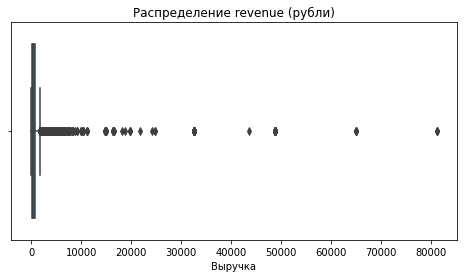

In [17]:
plt.figure(figsize=(8,4))
sns.boxplot(x=final_tickets_orders_df_rub['revenue'])
plt.title('Распределение revenue (рубли)')
plt.xlabel('Выручка')
plt.show()

Тут видно, что есть несколько очень больших значений, которые аж могут уходить за 80000. Чтобы от них избавится, отберем значением по 99 процентилю

In [18]:
df_no_rub = df[df['currency_code'] != 'rub']
quant = final_tickets_orders_df_rub['revenue'].quantile(0.99)
final_tickets_orders_df_rub = final_tickets_orders_df_rub[final_tickets_orders_df_rub['revenue'] <= quant]
df = pd.concat([df_no_rub, final_tickets_orders_df_rub], ignore_index=True)
s = df[df['revenue'] < 0].shape[0]
print(f'Количество удаляемых строк с отрицательным revenue: {s}')
df = df[df['revenue']>=0]

Количество удаляемых строк с отрицательным revenue: 381


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287400 entries, 0 to 287780
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287400 non-null  int64         
 1   user_id                 287400 non-null  object        
 2   created_dt_msk          287400 non-null  datetime64[ns]
 3   created_ts_msk          287400 non-null  datetime64[ns]
 4   event_id                287400 non-null  int64         
 5   cinema_circuit          287400 non-null  object        
 6   age_limit               287400 non-null  int64         
 7   currency_code           287400 non-null  object        
 8   device_type_canonical   287400 non-null  object        
 9   revenue                 287400 non-null  float64       
 10  service_name            287400 non-null  object        
 11  tickets_count           287400 non-null  int64         
 12  total                   287400

In [20]:
final_tickets_orders_df_rub = df[df['currency_code'] == 'rub']
final_tickets_orders_df_rub[['revenue','tickets_count']].describe()

,revenue,tickets_count
count,282331.000000,282331.000000
mean,511.519741,2.740939
std,500.918545,1.163539
min,0.000000,1.000000
25%,113.040000,2.000000
50%,341.730000,3.000000
75%,782.480000,3.000000
max,2570.800000,57.000000


В проверке на выбросы у рубля мы видим, что минимальная выручка почему-то уходит в отрицательное значение, такого быть не может, поэтому мы отфильтруем наш датасет дальше так, чтоб они не были ее частью. В целом, данные по тенге и рублю по остальным параметрам в порядке. Теперь мы видим, что строк в нашем изначальном датасете уменьшилось на 3181 значений, и при повторной проверке, мы видим, что стандартное отклонение стало меньше.

In [21]:
final_tickets_orders_df_kzt = df[df['currency_code'] == 'kzt']
final_tickets_orders_df_kzt[['revenue','tickets_count']].describe()

,revenue,tickets_count
count,5069.000000,5069.000000
mean,4995.206767,2.762872
std,4916.752776,1.115558
min,0.000000,1.000000
25%,518.100000,2.000000
50%,3698.830000,3.000000
75%,7397.660000,4.000000
max,26425.860000,6.000000


Проверку на выбросы Тенге прошла успешно, проблем там нету.В результате обработок данных с выбросами и с отрицательными значениями, у датасета осталось 287400 строк с данными.

#### Новые столбцы в датасете

In [22]:
def get_season(month):
    if month in [12, 1, 2]:
        return "зима"
    elif month in [3, 4, 5]:
        return "весна"
    elif month in [6, 7, 8]:
        return "лето"
    else:
        return "осень"

In [23]:
df['revenue_rub'] = df.apply(
    lambda row: row['revenue'] if row ['currency_code'] == 'rub' else row['revenue'] * (row['curs']/100),axis = 1)

df['one_ticket_revenue_rub'] = df['revenue_rub']/df['tickets_count']

df['month'] = df['created_dt_msk'].dt.month

df['season'] = df['month'].apply(get_season)

df.info()
df.head(100)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287400 entries, 0 to 287780
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287400 non-null  int64         
 1   user_id                 287400 non-null  object        
 2   created_dt_msk          287400 non-null  datetime64[ns]
 3   created_ts_msk          287400 non-null  datetime64[ns]
 4   event_id                287400 non-null  int64         
 5   cinema_circuit          287400 non-null  object        
 6   age_limit               287400 non-null  int64         
 7   currency_code           287400 non-null  object        
 8   device_type_canonical   287400 non-null  object        
 9   revenue                 287400 non-null  float64       
 10  service_name            287400 non-null  object        
 11  tickets_count           287400 non-null  int64         
 12  total                   287400

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,city_name,city_id,venue_id,venue_name,venue_address,curs,revenue_rub,one_ticket_revenue_rub,month,season
0,7850214,0033403583a55ed,2024-09-17,2024-09-17 16:52:06,559919,нет,6,kzt,mobile,518.10,...,Серебрянка,163.0,1533.0,"Клуб настольного тенниса ""Фазенда"" Инк","пер. Семашко, д. 8/7 стр. 7",19.0125,98.503762,24.625941,9,осень
1,8634925,0040e12d70fae81,2024-09-02,2024-09-02 19:49:14,559476,нет,6,kzt,desktop,347.18,...,Серебрянка,163.0,1533.0,"Клуб настольного тенниса ""Фазенда"" Инк","пер. Семашко, д. 8/7 стр. 7",18.9330,65.731589,21.910530,9,осень
2,7625522,0054b38b2653e6e,2024-09-09,2024-09-09 18:06:04,559582,нет,6,kzt,mobile,328.77,...,Серебрянка,163.0,1533.0,"Клуб настольного тенниса ""Фазенда"" Инк","пер. Семашко, д. 8/7 стр. 7",18.5991,61.148261,15.287065,9,осень
3,720419,00f4f5244501ce6,2024-06-11,2024-06-11 20:15:57,536826,нет,12,kzt,mobile,22021.55,...,Серебрянка,163.0,2066.0,"Архитектурное бюро ""Секрет"" Инк","пер. Проточный, д. 70 к. 881",19.8928,4380.702898,876.140580,6,лето
4,5227657,01370a0e9c1a7d5,2024-06-04,2024-06-04 13:28:17,533803,нет,16,kzt,desktop,7397.66,...,Широковка,162.0,3407.0,"Арт-кафе ""Речка"" Лимитед","алл. Путейская, д. 548 стр. 7",19.9833,1478.296591,369.574148,6,лето
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5589113,04b6911607ebb3e,2024-06-11,2024-06-11 23:20:10,536825,нет,12,kzt,mobile,10338.19,...,Широковка,162.0,2169.0,"Кладбище искусств ""Феномен"" Инк","ш. Саратовское, д. 73 стр. 367",19.8928,2056.555460,685.518487,6,лето
96,7589011,04b6911607ebb3e,2024-06-11,2024-06-11 12:14:26,536826,нет,12,kzt,desktop,8808.62,...,Серебрянка,163.0,2066.0,"Архитектурное бюро ""Секрет"" Инк","пер. Проточный, д. 70 к. 881",19.8928,1752.281159,876.140580,6,лето
97,7589069,04b6911607ebb3e,2024-06-11,2024-06-11 12:18:49,536826,нет,12,kzt,desktop,17617.24,...,Серебрянка,163.0,2066.0,"Архитектурное бюро ""Секрет"" Инк","пер. Проточный, д. 70 к. 881",19.8928,3504.562319,876.140580,6,лето
98,7589040,04b6911607ebb3e,2024-06-11,2024-06-11 12:22:16,536826,нет,12,kzt,desktop,17617.24,...,Серебрянка,163.0,2066.0,"Архитектурное бюро ""Секрет"" Инк","пер. Проточный, д. 70 к. 881",19.8928,3504.562319,876.140580,6,лето


Выше видно, что бы добавлены новые столбцы, но самое главное, курс с тенге был переведе на русскую валюту, о чем нам говорит строка 99 и столбец revenue_rub, тут он умножает курс актуальный курс тенге по дате оформления заказа и умножает ее выручку, которая указана в Тенге в столбце revenue, и дальше делит ее на номинал, тоесть 100, получается изначально revenue было 328, но в тенге, после перевода на российские рубли, выручка в рублях составила всего 61 рубль.

#### Тип данных

In [24]:
# Функции, которые автоматически подбирают нужный числовой тип данных и заменяют его
def optimize_memory_usage(x: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] 
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = x.memory_usage().sum() / 1024**2    
    for column in x.columns:
        column_type = x[column].dtypes
        if column_type in numerics:
            column_min = x[column].min()
            column_max = x[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    x[column] = x[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    x[column] = x[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    x[column] = x[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    x[column] = x[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    x[column] = x[column].astype(np.float32)
                else:
                    x[column] = x[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = x.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return x

In [25]:
df=optimize_memory_usage(df)
df.info()

Размер использования памяти: до 65.78 Mb - после 49.06 Mb (25.4%)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 287400 entries, 0 to 287780
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                287400 non-null  int32         
 1   user_id                 287400 non-null  object        
 2   created_dt_msk          287400 non-null  datetime64[ns]
 3   created_ts_msk          287400 non-null  datetime64[ns]
 4   event_id                287400 non-null  int32         
 5   cinema_circuit          287400 non-null  object        
 6   age_limit               287400 non-null  int8          
 7   currency_code           287400 non-null  object        
 8   device_type_canonical   287400 non-null  object        
 9   revenue                 287400 non-null  float32       
 10  service_name            287400 non-null  object        
 11  tickets_count           2

Решил добавить из прошлых проектов код на изменение количественных типов данных после добавления новых столбцоы, которые понадобятся для будущих рассчетов и визуализаций. Размер датасета уменьшился на 25 процентов. Были добавлены новые столбцы, которые означают:
- curs - курс тенге к рублю
- revenue_rub - выручка в рублях (в некоторых строках переведенная из тенге в рубли)
- one_ticket_revenue_rub - выручка с продажи одного билета на мероприятие
- month - номер месяца, который указан в дате создания заказа на билет
- season - время года, которое ориентируется на столбец month

## Исследовательский анализ данных

### Анализ распределения заказов по сегментам и их сезонные изменения

#### Количество заказов каждый месяц

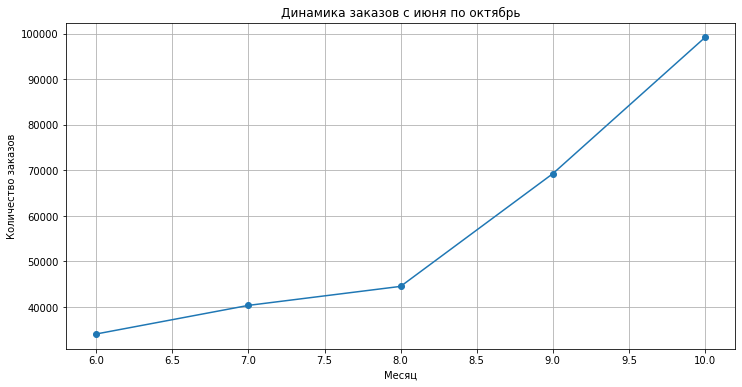

In [26]:
orders_df = df.groupby('month')['order_id'].count()

plt.figure(figsize=(12, 6))
plt.plot(orders_df.index, orders_df.values,marker = 'o')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Динамика заказов с июня по октябрь')
plt.grid()
plt.show()

Тут видно, что количество зказов стремительно начало рости с августа месяца по октябрь и достига аж 100.000. До этой даты, мы видим небольшой рост значений. Увеличение заказов от июня есть, причем значение выросло аж на 60000 заказов.

#### Распределение заказов билетов по категориям

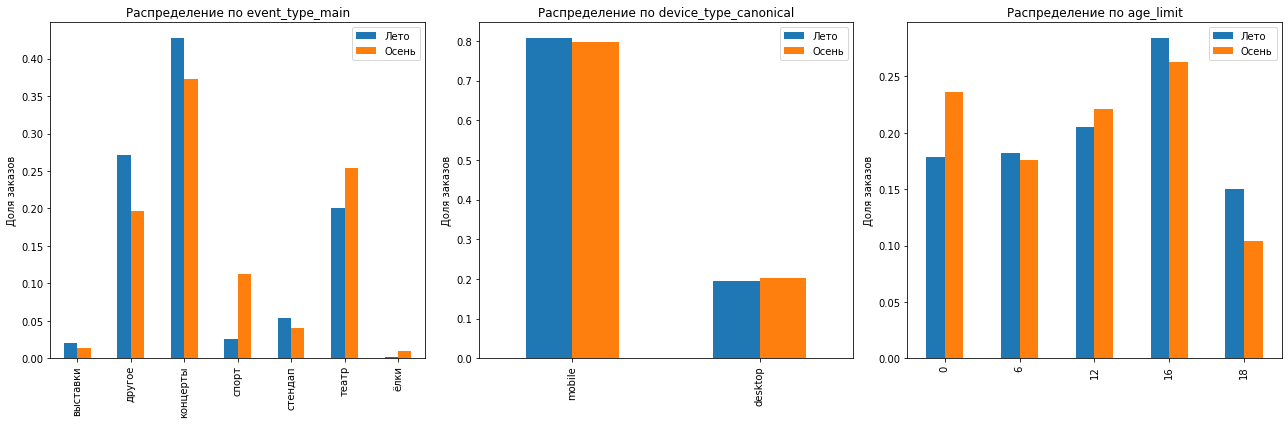

In [27]:
categories = ['event_type_main', 'device_type_canonical', 'age_limit']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, category in enumerate(categories):
    summer = df[df['season'] == 'лето'][category].value_counts(normalize=True)
    autumn = df[df['season'] == 'осень'][category].value_counts(normalize=True)

    df_compare = pd.DataFrame({'Лето': summer, 'Осень': autumn})
    df_compare.plot(kind="bar", ax=axes[i])

    axes[i].set_title(f'Распределение по {category}')
    axes[i].set_ylabel('Доля заказов')

plt.tight_layout()
plt.show()

- На первом графике видно, что по 5 пунктам из 7 представленных, лето обгоняет осень, в некоторых случаях отрыв сильный.Это может нам говорить о том, что эти мероприятия летом пользуются больше спросом нежели летом. 
- На втором графике сильного отрыва у какого-либо времени года нету, они практически идут вровень, что говорит нам об активном использовании мобильного устройства, и станионарного, но доля мобильный гораздо выше, чем стационарных.
- На третьем графике мы видим распределение по возрасту. Сразу в глаза бросается отрыв осени в категории 0 и отрыв лета в категории 18.

#### Измение выручки с продажи одного билета 

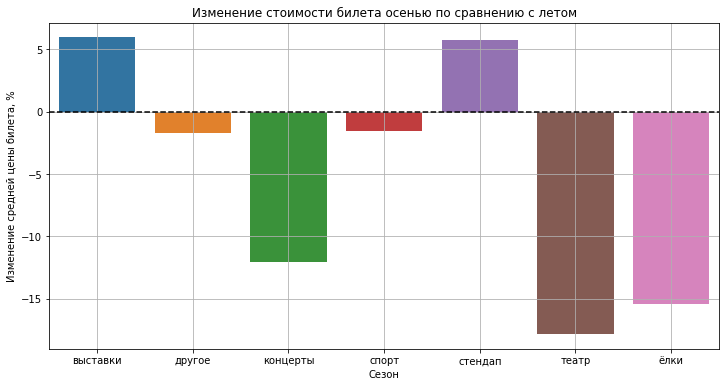

In [28]:
summer_price = df[df['season'] == 'лето'].groupby('event_type_main')['one_ticket_revenue_rub'].mean()
autumn_price = df[df['season'] == 'осень'].groupby('event_type_main')['one_ticket_revenue_rub'].mean()
 
price_change = ((autumn_price - summer_price) / summer_price * 100)   
    
plt.figure(figsize=(12, 6))
sns.barplot(x=price_change.index, y=price_change.values)
plt.axhline(0, color="black", linestyle="--")
plt.xlabel('Сезон')
plt.ylabel('Изменение средней цены билета, %')
plt.title('Изменение стоимости билета осенью по сравнению с летом')
plt.grid()
plt.show()

Тут мы видим, что в большинстве своем, цены осенью цены снизились на такие категории мероприятий как: концерты, ёлки, театр, спорт и другое. Но и на некоторые и выросли, аж на 10 процентов, можем сделать вывод, что основной сезон таких мероприятий как:концерты и спорт приходится на лето, так как чаще всего данные мероприятия проходят на улице, что говорит нам о нужде в хорошей погоде. Следовательно сезон этих мероприятий закончился, вот и снижение цен на мероприятия.

### Осенняя активность пользователей

#### Динамика изменений по дням

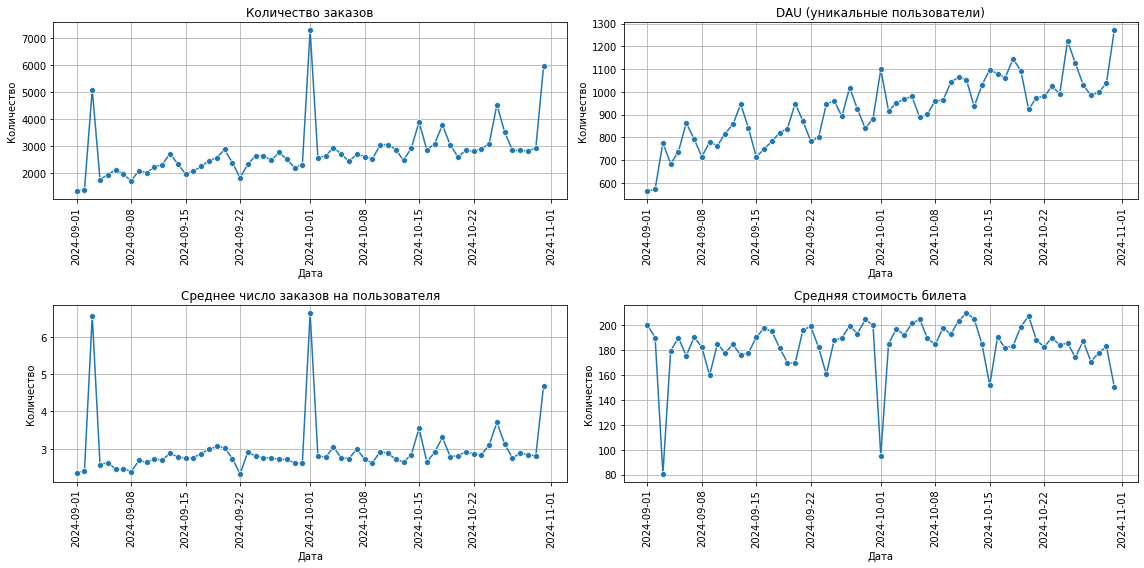

In [29]:
autumn_df = df[df['season']=='осень']
daily_metrics = autumn_df.groupby(autumn_df['created_dt_msk']).agg(
    orders_count = ('order_id','count'),
    DAU = ('user_id','nunique'),
    avg_ticket_price = ('one_ticket_revenue_rub','mean')
).reset_index()

daily_metrics["avg_orders_per_user"] = daily_metrics["orders_count"] / daily_metrics["DAU"]

metrics = ['orders_count', 'DAU', 'avg_orders_per_user','avg_ticket_price']
titles = ["Количество заказов", "DAU (уникальные пользователи)", 
          "Среднее число заказов на пользователя", "Средняя стоимость билета"]

fig, axes = plt.subplots(2, 2, figsize=(16, 8))

for i, metrics in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    sns.lineplot(x=daily_metrics['created_dt_msk'], y=daily_metrics[metrics],marker = 'o',ax=ax)
    ax.set_title(titles[i])
    ax.set_xlabel('Дата')
    ax.set_ylabel('Количество')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()

plt.tight_layout()    
plt.show()

- Количество заказов — наблюдается общий тренд к увеличению с конца сентября по ноябрь. Отдельные пики могут быть связаны с крупными мероприятиями.

- DAU (уникальные пользователи) — также демонстрирует рост, особенно в октябре.

- Среднее число заказов на пользователя — незначительные колебания, но без выраженной тенденции к росту или падению.

- Средняя стоимость билета — относительно стабильна, за исключением нескольких дней с резкими изменениями.

По трем графикам можно предположить такой резкий скачок на начало октября, в те дни билеты резко снизили свою стоимость, что среднее их значение немного было меньше 100, отсюда и большое кол-во закаов за день и среднее кол-во заказ на пользователя возросло.Осенью фиксируется рост заказов и DAU, что подтверждает сезонное увеличение спроса.

#### Динамика изменений по дням недели

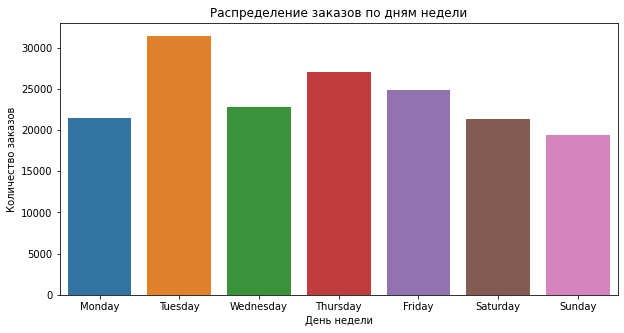

In [30]:
autumn_df = autumn_df.copy()
autumn_df['weekday'] = autumn_df['created_dt_msk'].dt.day_name()
weekly_metrics = autumn_df.groupby('weekday').agg(
    orders_count=('order_id', 'count'),
    unique_users=('user_id', 'nunique'),
).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

weekly_metrics['avg_orders_per_user'] = weekly_metrics['orders_count'] / weekly_metrics['unique_users']

plt.figure(figsize=(10, 5))
sns.barplot(x=weekly_metrics.index, y=weekly_metrics["orders_count"])
plt.xlabel("День недели")
plt.ylabel("Количество заказов")
plt.title("Распределение заказов по дням недели")
plt.show()

Вторник и четверг являются самыми популярными днями для заказов, а в выходные кол-во заказов снижается. Отсюда и вывод, что пользователи чаще совершают заказы в будние дни, особенно во вторник и четверг.

### Популярные события и партнёры

#### Уникальное кол-во мероприятий и числа заказов по регионам

In [31]:
region_analysis = autumn_df.groupby('region_name').agg(
    unqiue_events = ('event_id','nunique'),
    orders_count = ('order_id','count'),
).reset_index()

region_analysis['event_share'] = region_analysis['unqiue_events'] / region_analysis['unqiue_events'].sum()
region_analysis['order_share'] = region_analysis['orders_count'] / region_analysis['orders_count'].sum()


region_analysis = region_analysis.sort_values(by = 'unqiue_events', ascending = False)

region_analysis.head(5)

,region_name,unqiue_events,orders_count,event_share,order_share
23,Каменевский регион,3910,46684,0.246843,0.277183
59,Североярская область,2611,20704,0.164836,0.122929
75,Широковская область,796,8648,0.050253,0.051347
56,Светополянский округ,762,4771,0.048106,0.028327
51,Речиновская область,529,3565,0.033396,0.021167


Каменевский райно и Североярская область лидируют по кол-ву мероприятий и заказов. Остальные регионы занимают меньшую долю заказов. Каменевский район является самым прибыльным, за ним следует Североярская область.

#### Уникальное кол-во мероприятий и выручка с закаов для билетного партнера

In [32]:
region_analysis = autumn_df.groupby('service_name').agg(
    unqiue_events = ('event_id','nunique'),
    orders_count = ('order_id','count'),
    total_revenue = ('revenue','sum')
).reset_index()

region_analysis['event_share'] = region_analysis['unqiue_events'] / region_analysis['unqiue_events'].sum()
region_analysis['order_share'] = region_analysis['orders_count'] / region_analysis['orders_count'].sum()
region_analysis['revenue_share'] = region_analysis['total_revenue'] / region_analysis['total_revenue'].sum()

region_analysis = region_analysis.sort_values(by = 'orders_count', ascending = False)

region_analysis.head(5)

,service_name,unqiue_events,orders_count,total_revenue,event_share,order_share,revenue_share
3,Билеты без проблем,2836,32328,13595150.0,0.164292,0.191945,0.161527
21,Лови билет!,3611,25772,10381965.0,0.209188,0.153019,0.123350
5,Билеты в руки,2457,25646,7613839.5,0.142336,0.152271,0.090462
24,Мой билет,1005,19416,11636746.0,0.058220,0.115281,0.138259
25,Облачко,1409,15478,10611052.0,0.081624,0.091900,0.126072


Билеты без проблем лидирует по кол-ву проодаж и общей выручке, но Лови Билет! на 775 мероприятия провела больше. Это нам говорит о том, что Билеты без проблем занимают основную долю от выручки и кол-во заказов, но Лови Билет! является основной в доле по проведнию уникальных мероприятийю. За ними идет сервис Билеты в руки, которые немного отстает от Билеты без проблем по мероприятиям и чуть чуть отстает от кол-во заказов Лови Билет, но общая выручка у нее в 2 раза меньше лидера по продажам.

## Статистический анализ данных

In [33]:
user_orders = autumn_df.groupby(['user_id','device_type_canonical']).agg(
    total_orders = ('order_id','count'),
    avg_days_since_prev = ('days_since_prev', 'mean')
).reset_index()

alpha = 0.05

mobile = user_orders[user_orders['device_type_canonical']=='mobile']
desktop = user_orders[user_orders['device_type_canonical']=='desktop']

print('Среднее количество заказов на пользователя (мобильные):', mobile['total_orders'].mean())
print('Среднее количество заказов на пользователя (десктоп):', desktop['total_orders'].mean())

print('Среднее время между заказами (мобильные)', mobile['avg_days_since_prev'].mean())
print('Среднее время между заказами (десктоп)', desktop['avg_days_since_prev'].mean())

Среднее количество заказов на пользователя (мобильные): 9.456500282007896
Среднее количество заказов на пользователя (десктоп): 7.044371405094495
Среднее время между заказами (мобильные) 20.627174
Среднее время между заказами (десктоп) 14.858363


### Среднее количество заказов

- Нулевая гипотеза H₀: У мобильных пользователей среднее количество заказов не больше чем у  стационарных пользователей.

- Альтернативная гипотеза H₁: Пользователи мобильных устройств делают больше заказов.

In [34]:
results = st.mannwhitneyu(
    mobile["total_orders"], 
    desktop["total_orders"],
    alternative='greater',
)

print('p-значение:', round(results.pvalue,4))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: пользователи мобильных устройств делают больше заказов.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу: статистически значимых различий нет.')

p-значение: 0.0
Отвергаем нулевую гипотезу: пользователи мобильных устройств делают больше заказов.


### Среднее время между заказами

- Нулевая гипотеза H₀: Разницы во времени между заказами у мобильных не больше чем у  стационарных пользователей.

- Альтернативная гипотеза H₁: Пользователи мобильных устройств делают заказы реже, то есть время между заказами больше.

In [35]:
results1 = st.mannwhitneyu(
   mobile["avg_days_since_prev"].dropna(), 
   desktop["avg_days_since_prev"].dropna(),
   alternative='greater',
)

print('p-значение:', round(results1.pvalue,4))

if results1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: Пользователи мобильных устройств делают заказы реже, то есть время между заказами больше')
else:
    print('Нет оснований отвергнуть нулевую гипотезу: статистически значимых различий нет.')

p-значение: 0.0
Отвергаем нулевую гипотезу: Пользователи мобильных устройств делают заказы реже, то есть время между заказами больше


Я выбрал тест Манна-Уитни потому что:

- Устойчив к выбросам

- Не требует нормального распределения

- Не требует равенства дисперсий

- Работает даже при разных размерах выборок

Два результат показали нам значение меньше значения alpha, тоесть <0.5, что говорит нам об отвержение нулевой гипотезы и принятии альтернативной.

## Выводы и рекомендации

### Вывод

В ходе анализа были изучены данные о заказах билетов на различные мероприятия за осенний период. Данные включали информацию о типе устройства (мобильные/стационарные), типе мероприятия, количестве заказов, активности пользователей, выручке и других характеристиках. Также были учтены региональные особенности.

- Рост популярности мероприятий осенью:

Осенью наблюдается увеличение числа заказов и активности пользователей, что может быть связано с началом культурного сезона и возвращением людей к привычному ритму после летнего периода.

Самые популярные категории мероприятий: концерты, театр и спорт.

- Анализ пользовательской активности:

Наиболее активные дни для покупок — вторник и четверг. В эти дни фиксируется наибольшее количество заказов.

Средний чек оставался относительно стабильным, но наблюдались отдельные выбросы, указывающие на крупные покупки.

Среднее время между заказами у мобильных пользователей выше, что может свидетельствовать о менее частых, но более крупных покупках через мобильное приложение.

- Региональный анализ:

Ключевые рынки по объему заказов:

Каменевский регион — лидер по числу заказов и выручке.

Североярская область также входит в число ключевых регионов.

- Результаты проверки гипотез:

Гипотеза о том, что пользователи мобильных устройств делают больше заказов, подтвердилась.

Гипотеза о том, что время между заказами у мобильных пользователей больше, также нашла подтверждение.

### Рекомендации

- Учитывать сезонный рост спроса и адаптировать маркетинговые кампании к осеннему периоду.

Например за 1-2 месяца до осени запустить рекламные кампании с акцентом на осенние мероприятия (концерты, спорт, театр).

- Фокусироваться на будних днях (особенно вторниках и четвергах) для продвижения акций.

Например запустить специальные предложения «Скидка 10% на билеты по вторникам» или программа лояльности с бонусами за покупки в определённые дни.

- Развивать региональный маркетинг, особенно в Каменевском регионе и Североярской области.

Например сотрудничать с местными медиа и блогерами для рекламы мероприятий, таргетированной рекламы в социальных сетях именно на жителей этих регионов.

- Уделять больше внимания мобильным пользователям, так как они проявляют наибольшую активность.

Например оптимизировать мобильное приложение — добавить push-уведомления о снижении цен на интересующие билеты, удобные способы оплаты (Apple Pay, Google Pay, СБП), а также эксклюзивные скидки для мобильных пользователей.